# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install Pillow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 8.93 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

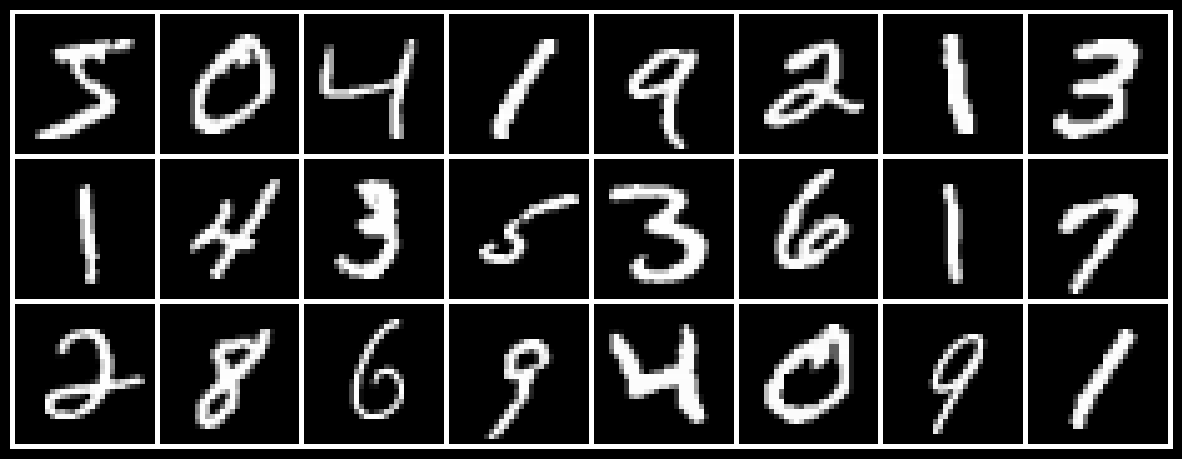

In [7]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


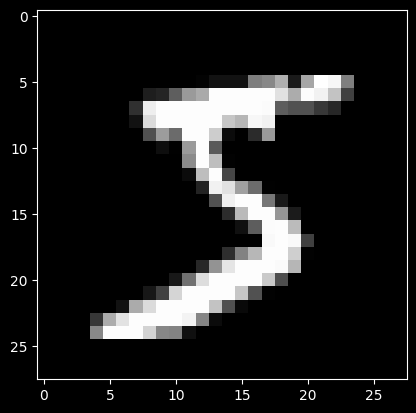

In [8]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [9]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [10]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.0104,  0.3347, -0.0102,  0.0896,  0.0928, -0.0556,  0.1772, -0.2733,
         -0.2019,  0.0044],
        [ 0.0433,  0.2144,  0.2033, -0.0447, -0.2205, -0.1872,  0.1197,  0.0910,
         -0.4452, -0.0842],
        [-0.2149, -0.0434, -0.0918,  0.0483,  0.0650, -0.1424,  0.3380,  0.0248,
         -0.0259, -0.1107],
        [ 0.0288, -0.0247, -0.0629, -0.2967,  0.2472, -0.0130, -0.1903, -0.0494,
         -0.0808, -0.0644],
        [ 0.1813,  0.0612,  0.1374, -0.1390,  0.1314, -0.1179,  0.1341,  0.2266,
         -0.2731,  0.1269]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [11]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [ ]:
! pip install graphviz
! pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-6v1m_zng
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-6v1m_zng
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [13]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3066, grad_fn=<NllLossBackward0>)

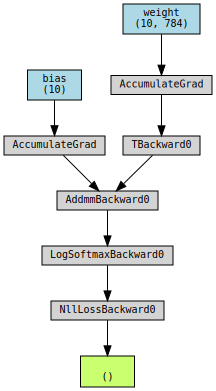

In [14]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [15]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [16]:
print('Final loss:', loss.item())

Final loss: 0.2656574845314026


### Visualizando gráfico de perda durante o treinamento

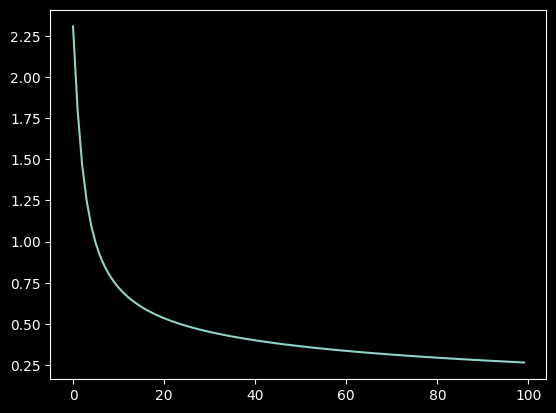

In [17]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [18]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.941


### Matriz de confusão com dados de treinamento e teste

In [19]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,111,2,0,0,0,2,2,1,0
2,0,0,90,2,0,1,0,1,2,1
3,0,0,0,87,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,1,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


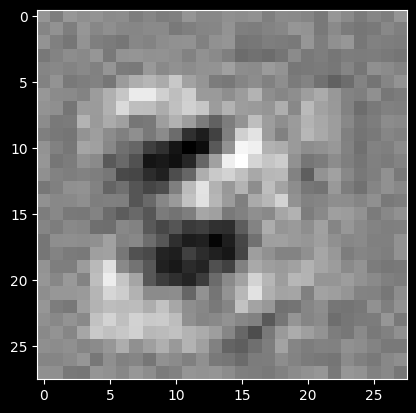

In [20]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

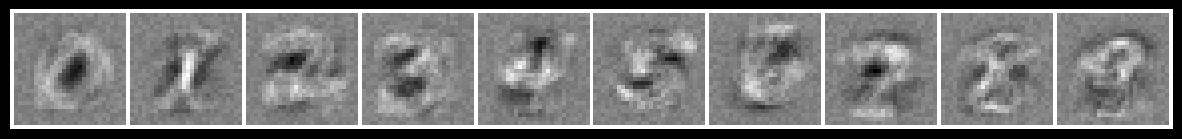

In [21]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [22]:
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    # Imprime o número da época, a perda e a acurácia
    print(f"Epoch [{i+1}/{epochs}], Loss: {loss.item():.6f}, Accuracy: {accuracy:.6f}")

Epoch [1/100], Loss: 0.264320, Accuracy: 0.941000
Epoch [2/100], Loss: 0.262998, Accuracy: 0.943000
Epoch [3/100], Loss: 0.261691, Accuracy: 0.943000
Epoch [4/100], Loss: 0.260400, Accuracy: 0.943000
Epoch [5/100], Loss: 0.259123, Accuracy: 0.943000
Epoch [6/100], Loss: 0.257861, Accuracy: 0.944000
Epoch [7/100], Loss: 0.256614, Accuracy: 0.944000
Epoch [8/100], Loss: 0.255380, Accuracy: 0.944000
Epoch [9/100], Loss: 0.254160, Accuracy: 0.944000
Epoch [10/100], Loss: 0.252954, Accuracy: 0.944000
Epoch [11/100], Loss: 0.251760, Accuracy: 0.944000
Epoch [12/100], Loss: 0.250579, Accuracy: 0.944000
Epoch [13/100], Loss: 0.249411, Accuracy: 0.945000
Epoch [14/100], Loss: 0.248256, Accuracy: 0.945000
Epoch [15/100], Loss: 0.247112, Accuracy: 0.946000
Epoch [16/100], Loss: 0.245980, Accuracy: 0.946000
Epoch [17/100], Loss: 0.244860, Accuracy: 0.946000
Epoch [18/100], Loss: 0.243751, Accuracy: 0.946000
Epoch [19/100], Loss: 0.242654, Accuracy: 0.946000
Epoch [20/100], Loss: 0.241567, Accuracy

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

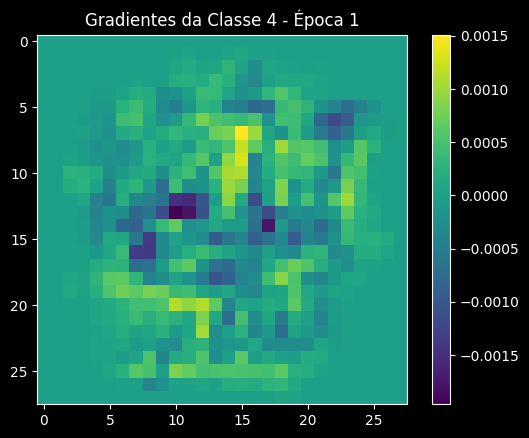

Epoch [1/100], Loss: 0.178119, Accuracy: 0.966000


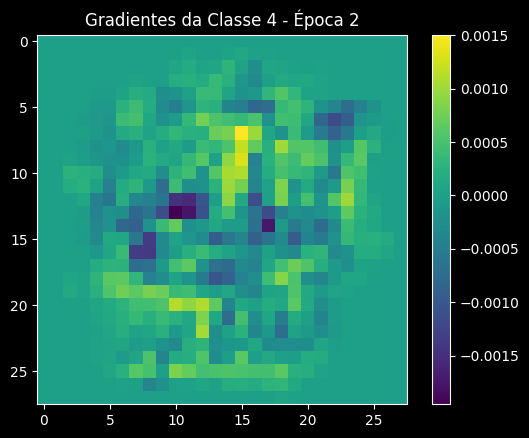

Epoch [2/100], Loss: 0.177544, Accuracy: 0.966000


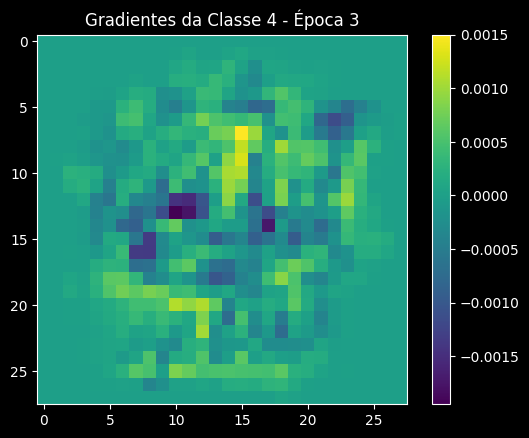

Epoch [3/100], Loss: 0.176973, Accuracy: 0.966000


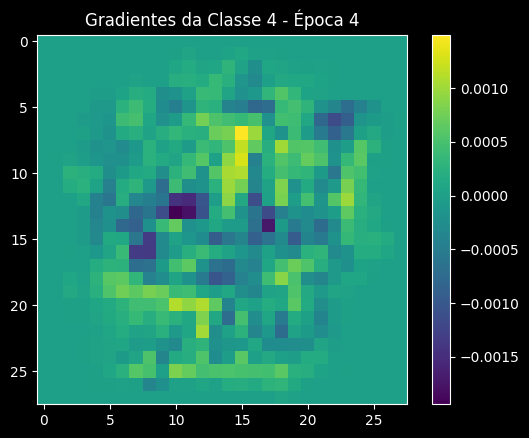

Epoch [4/100], Loss: 0.176405, Accuracy: 0.966000


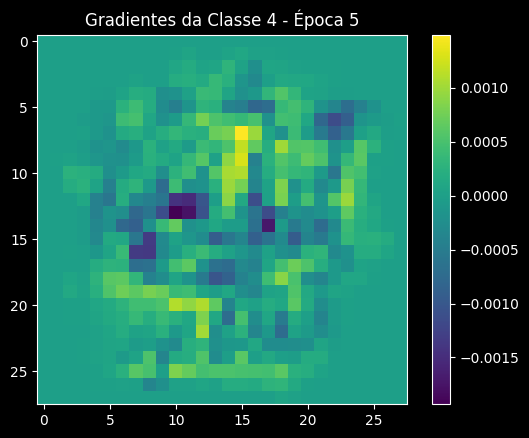

Epoch [5/100], Loss: 0.175841, Accuracy: 0.966000


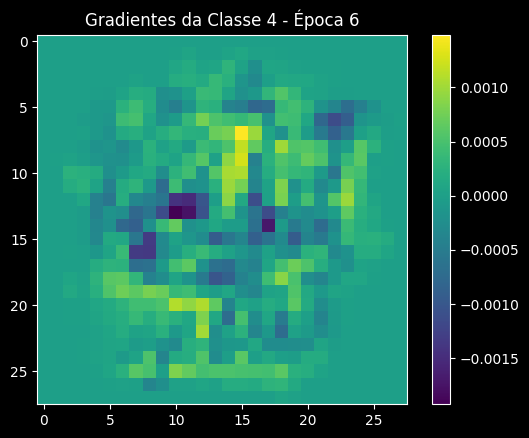

Epoch [6/100], Loss: 0.175280, Accuracy: 0.967000


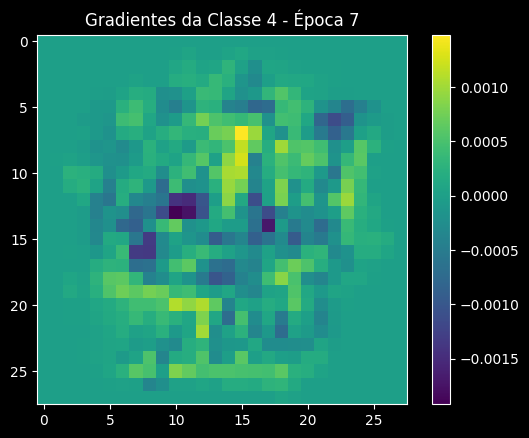

Epoch [7/100], Loss: 0.174722, Accuracy: 0.967000


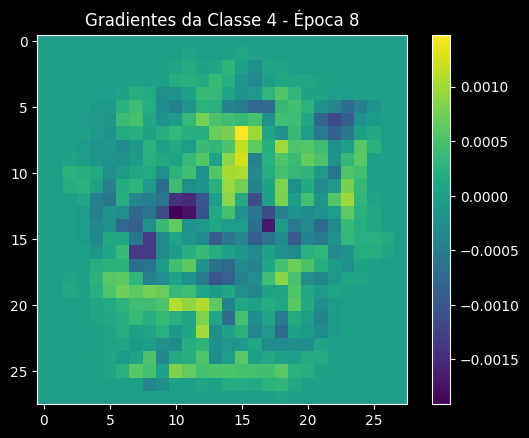

Epoch [8/100], Loss: 0.174168, Accuracy: 0.967000


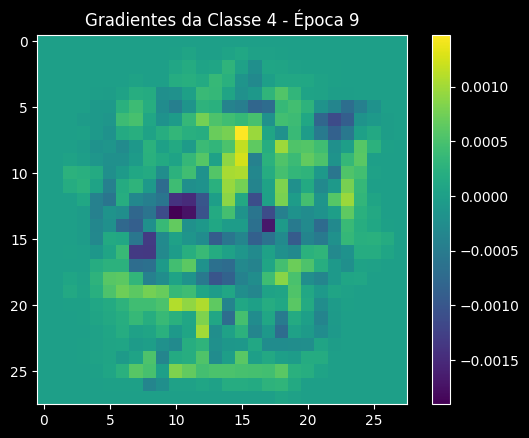

Epoch [9/100], Loss: 0.173617, Accuracy: 0.968000


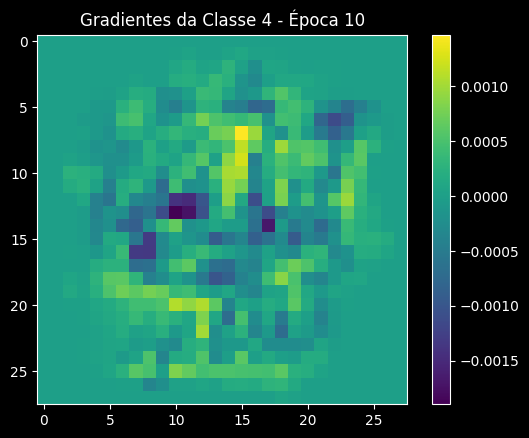

Epoch [10/100], Loss: 0.173070, Accuracy: 0.968000


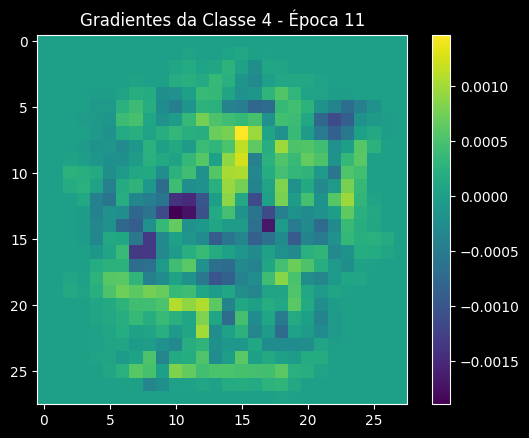

Epoch [11/100], Loss: 0.172526, Accuracy: 0.968000


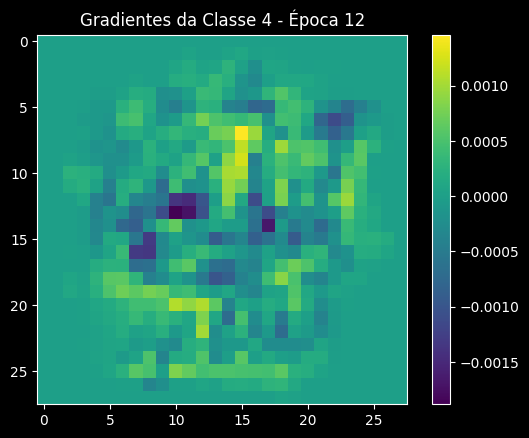

Epoch [12/100], Loss: 0.171985, Accuracy: 0.968000


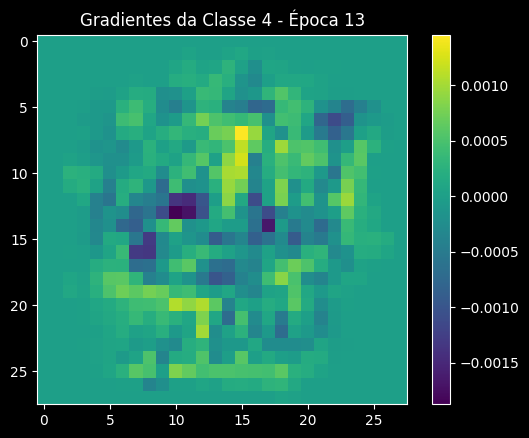

Epoch [13/100], Loss: 0.171447, Accuracy: 0.968000


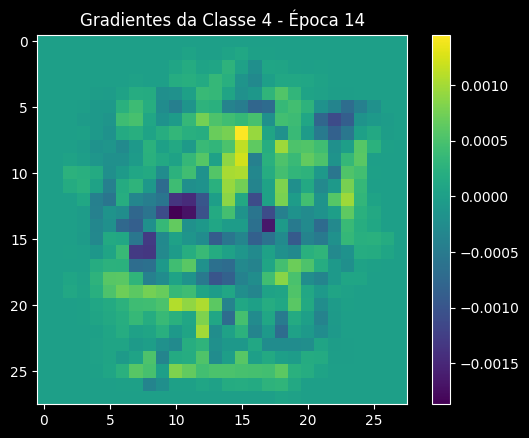

Epoch [14/100], Loss: 0.170913, Accuracy: 0.968000


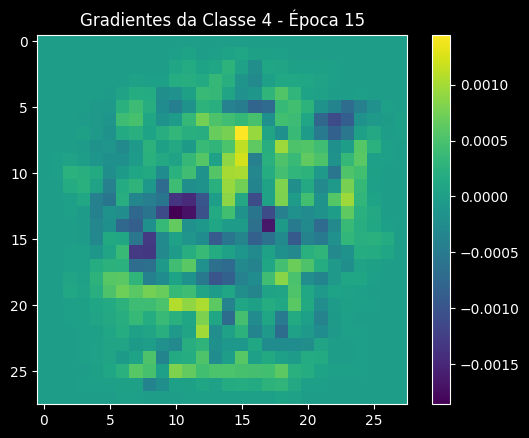

Epoch [15/100], Loss: 0.170381, Accuracy: 0.968000


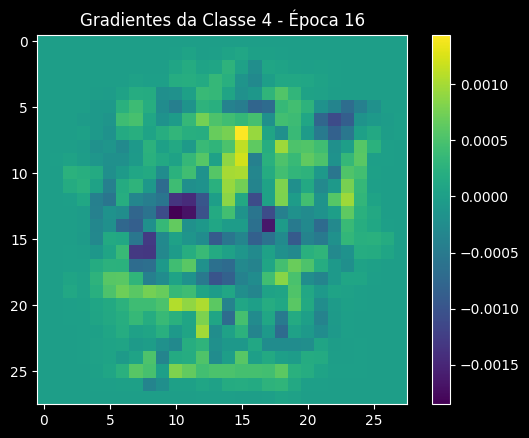

Epoch [16/100], Loss: 0.169853, Accuracy: 0.968000


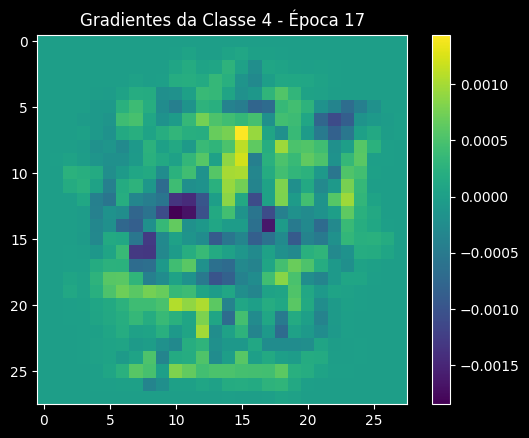

Epoch [17/100], Loss: 0.169328, Accuracy: 0.968000


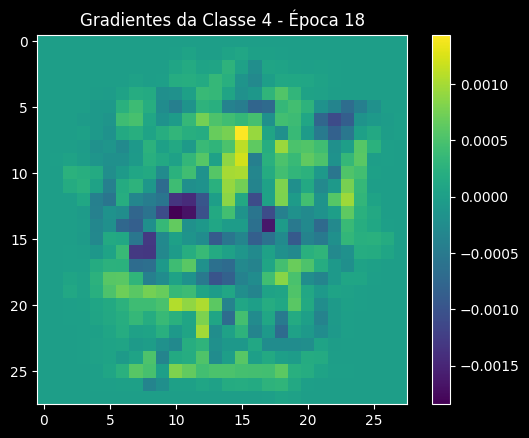

Epoch [18/100], Loss: 0.168806, Accuracy: 0.968000


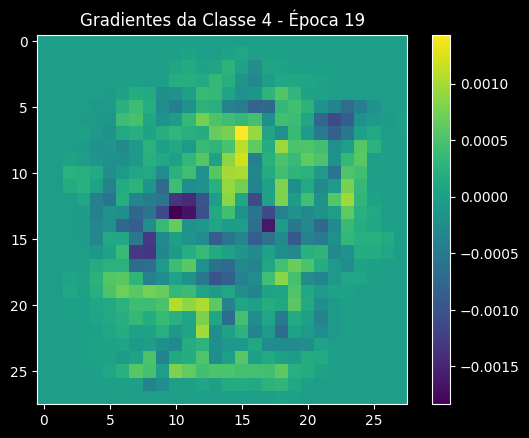

Epoch [19/100], Loss: 0.168287, Accuracy: 0.968000


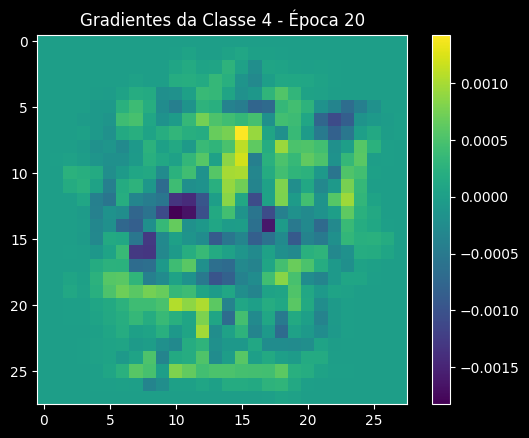

Epoch [20/100], Loss: 0.167771, Accuracy: 0.968000


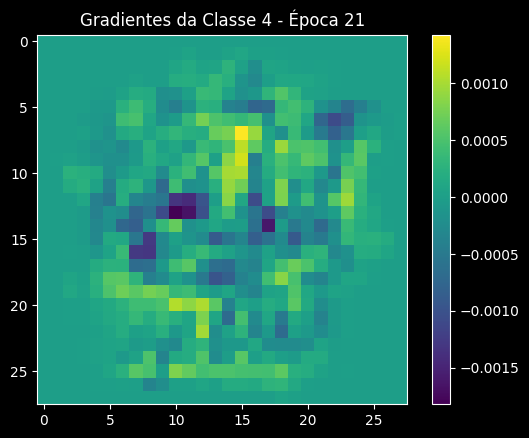

Epoch [21/100], Loss: 0.167258, Accuracy: 0.968000


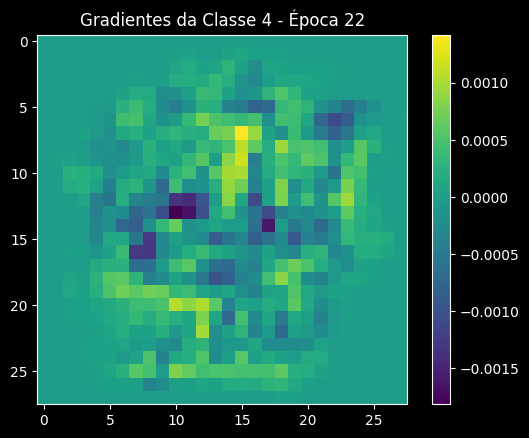

Epoch [22/100], Loss: 0.166748, Accuracy: 0.968000


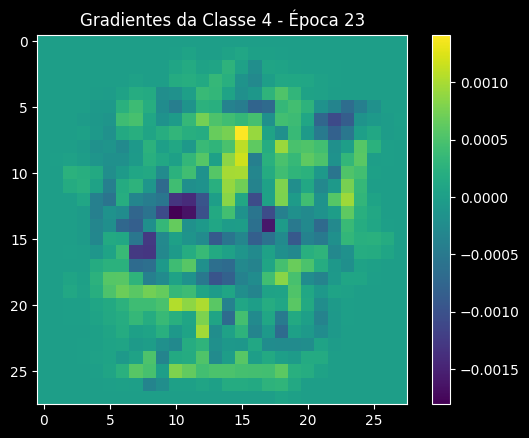

Epoch [23/100], Loss: 0.166241, Accuracy: 0.968000


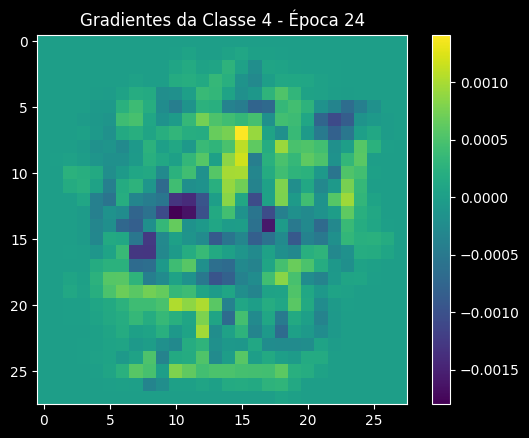

Epoch [24/100], Loss: 0.165736, Accuracy: 0.969000


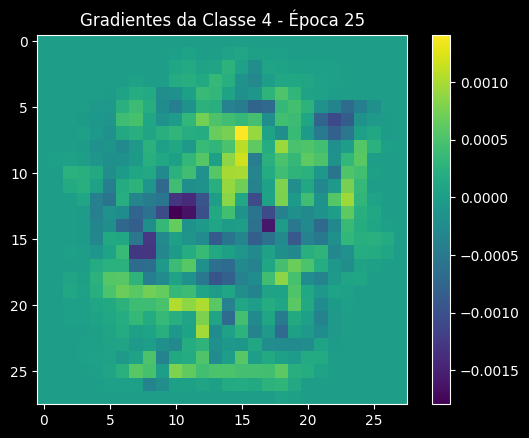

Epoch [25/100], Loss: 0.165235, Accuracy: 0.969000


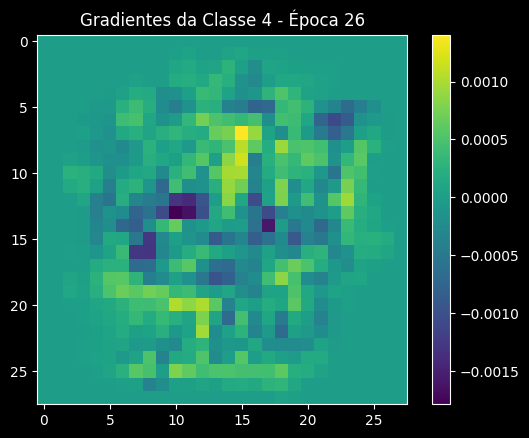

Epoch [26/100], Loss: 0.164736, Accuracy: 0.969000


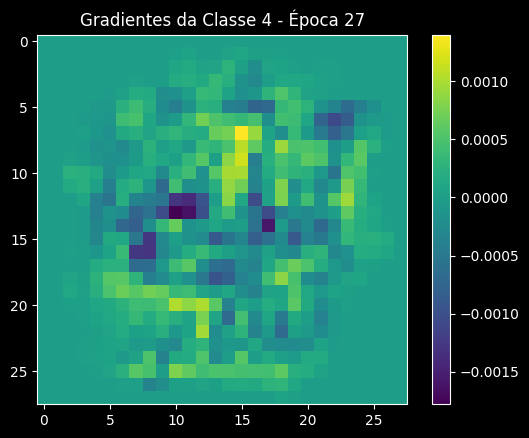

Epoch [27/100], Loss: 0.164241, Accuracy: 0.971000


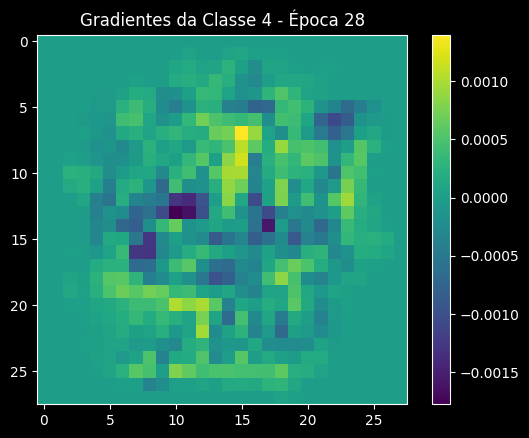

Epoch [28/100], Loss: 0.163748, Accuracy: 0.971000


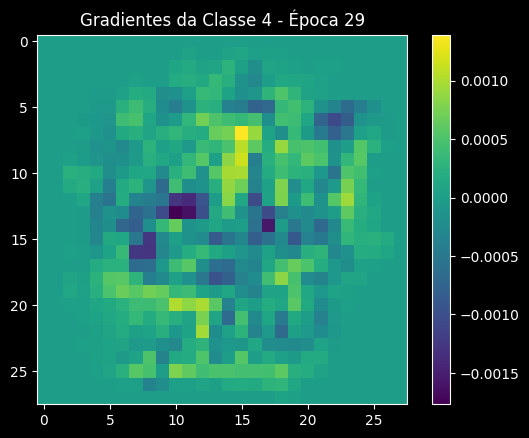

Epoch [29/100], Loss: 0.163258, Accuracy: 0.971000


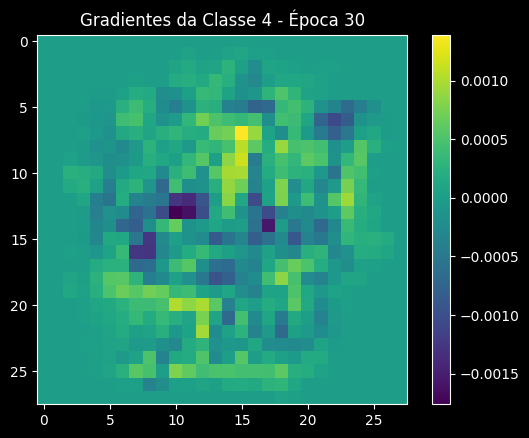

Epoch [30/100], Loss: 0.162770, Accuracy: 0.971000


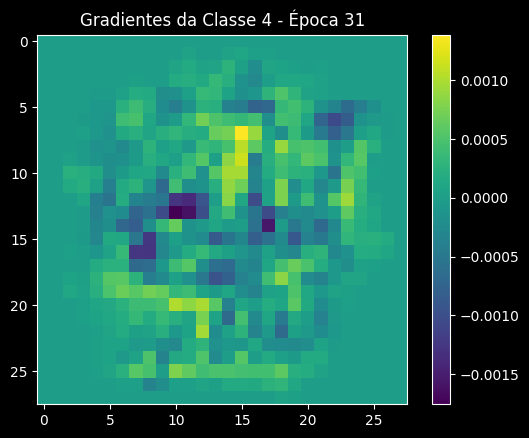

Epoch [31/100], Loss: 0.162286, Accuracy: 0.971000


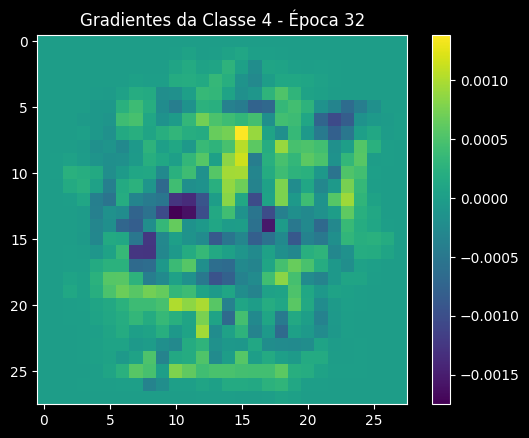

Epoch [32/100], Loss: 0.161804, Accuracy: 0.971000


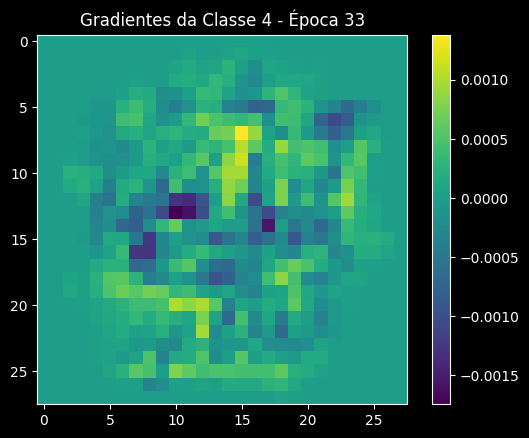

Epoch [33/100], Loss: 0.161324, Accuracy: 0.971000


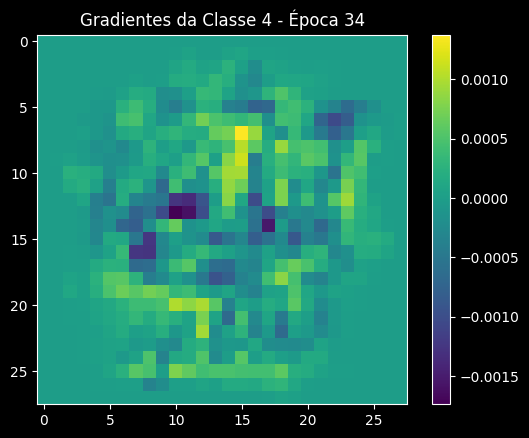

Epoch [34/100], Loss: 0.160848, Accuracy: 0.971000


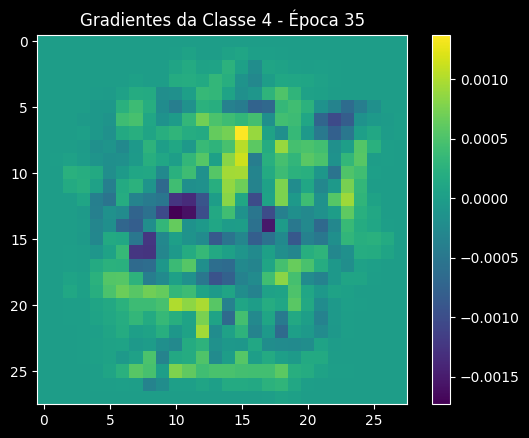

Epoch [35/100], Loss: 0.160374, Accuracy: 0.971000


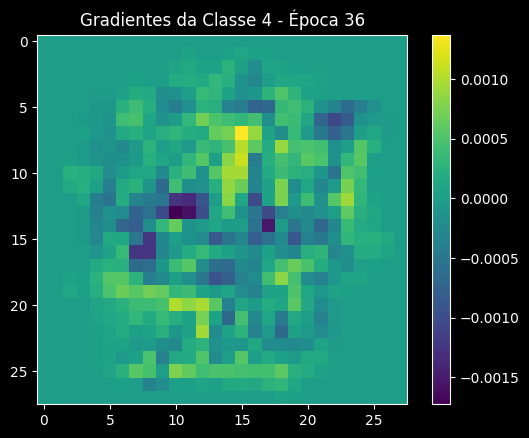

Epoch [36/100], Loss: 0.159902, Accuracy: 0.971000


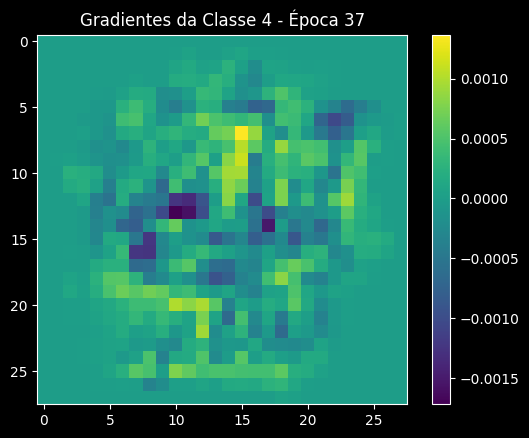

Epoch [37/100], Loss: 0.159433, Accuracy: 0.971000


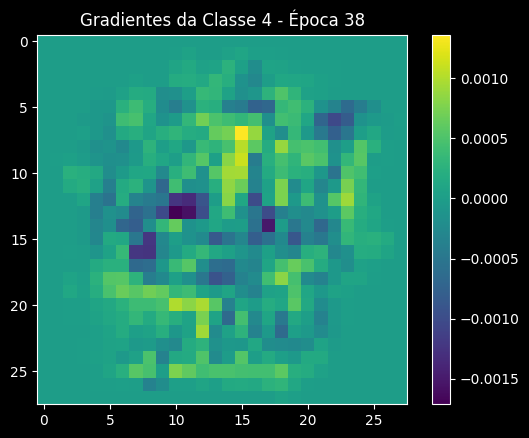

Epoch [38/100], Loss: 0.158967, Accuracy: 0.971000


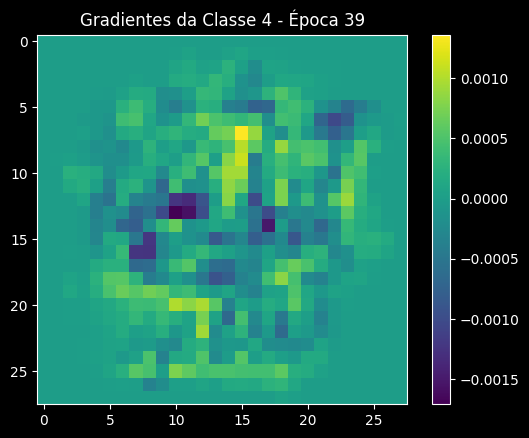

Epoch [39/100], Loss: 0.158503, Accuracy: 0.971000


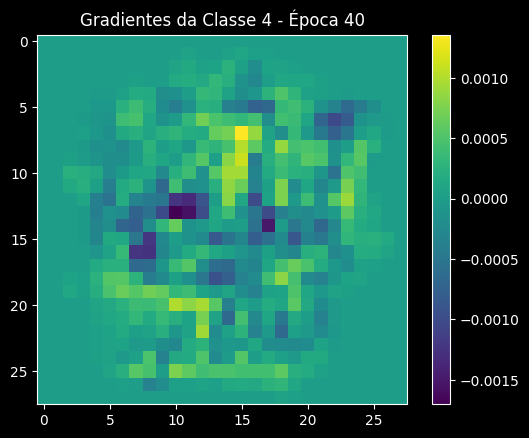

Epoch [40/100], Loss: 0.158042, Accuracy: 0.971000


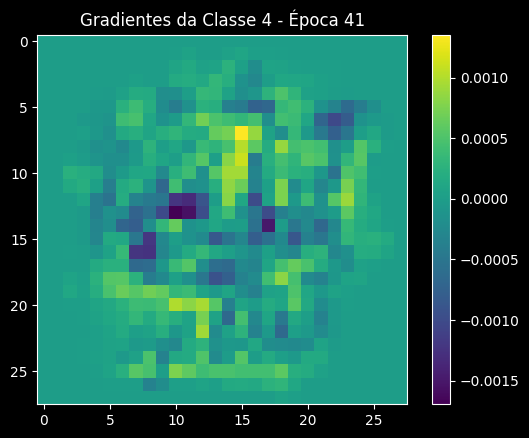

Epoch [41/100], Loss: 0.157583, Accuracy: 0.971000


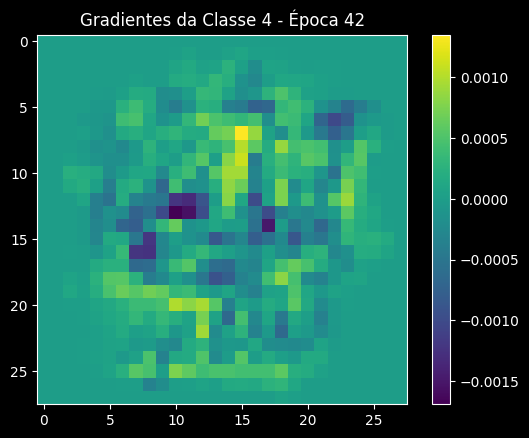

Epoch [42/100], Loss: 0.157127, Accuracy: 0.971000


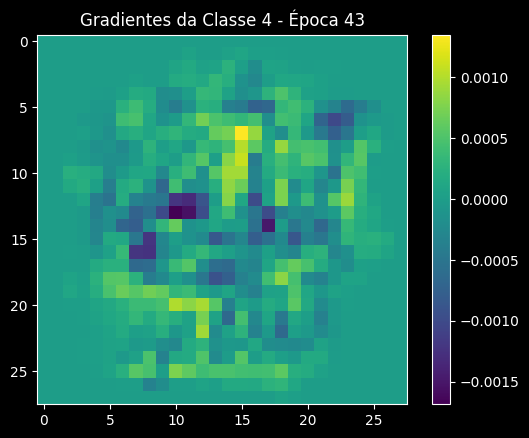

Epoch [43/100], Loss: 0.156673, Accuracy: 0.971000


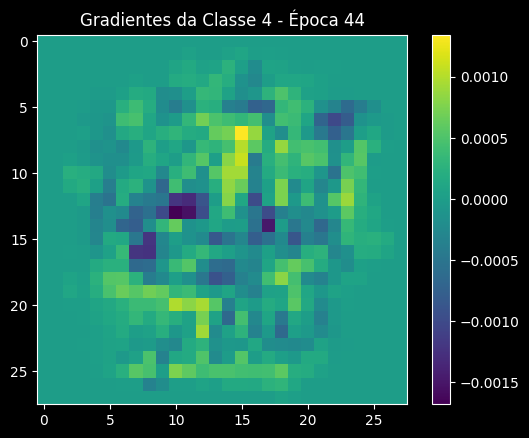

Epoch [44/100], Loss: 0.156221, Accuracy: 0.971000


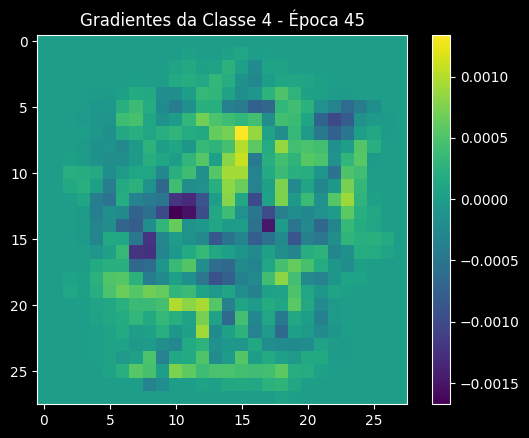

Epoch [45/100], Loss: 0.155772, Accuracy: 0.971000


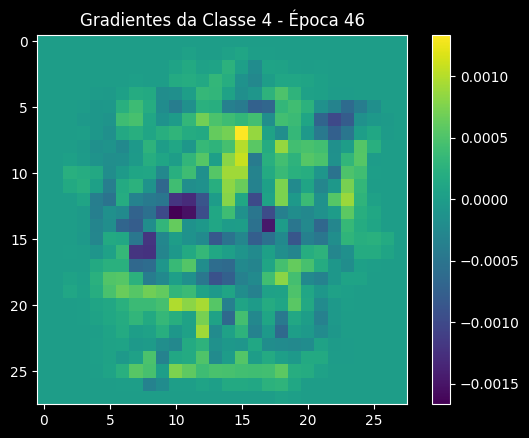

Epoch [46/100], Loss: 0.155325, Accuracy: 0.971000


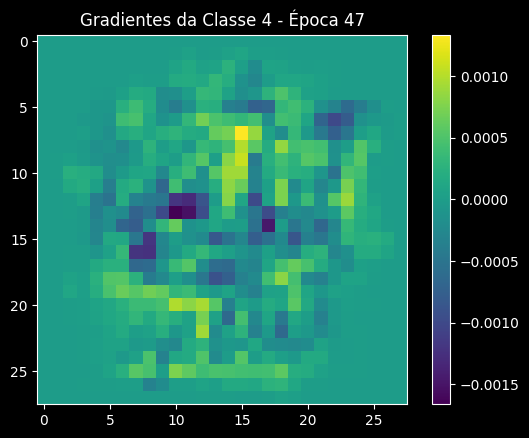

Epoch [47/100], Loss: 0.154881, Accuracy: 0.971000


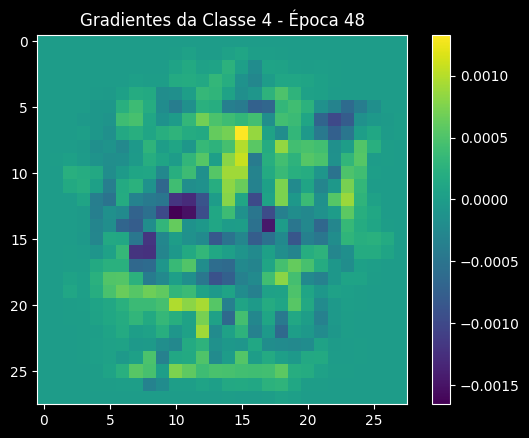

Epoch [48/100], Loss: 0.154439, Accuracy: 0.971000


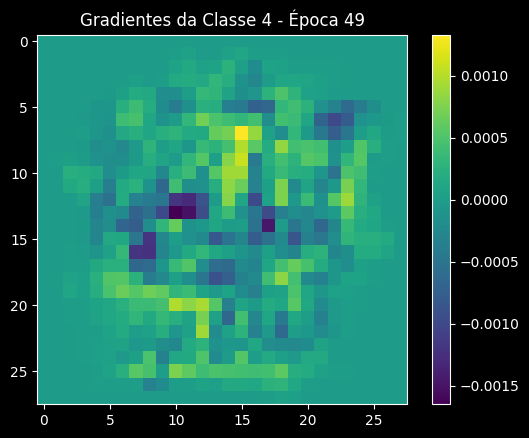

Epoch [49/100], Loss: 0.153999, Accuracy: 0.972000


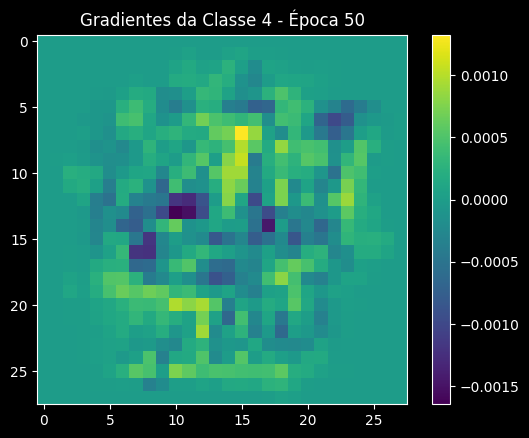

Epoch [50/100], Loss: 0.153562, Accuracy: 0.973000


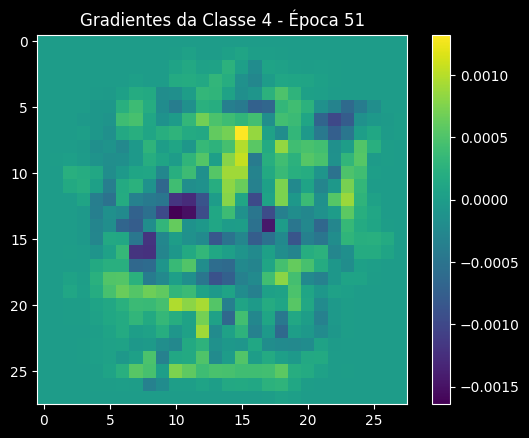

Epoch [51/100], Loss: 0.153127, Accuracy: 0.973000


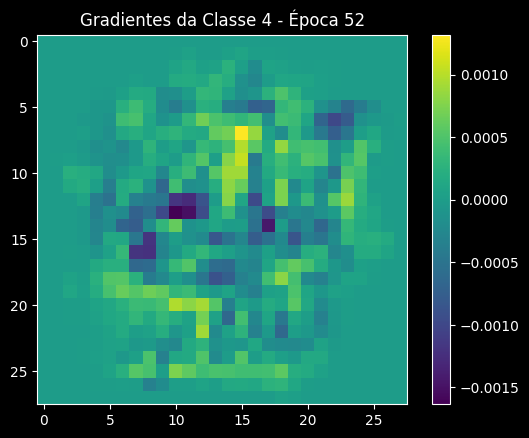

Epoch [52/100], Loss: 0.152694, Accuracy: 0.974000


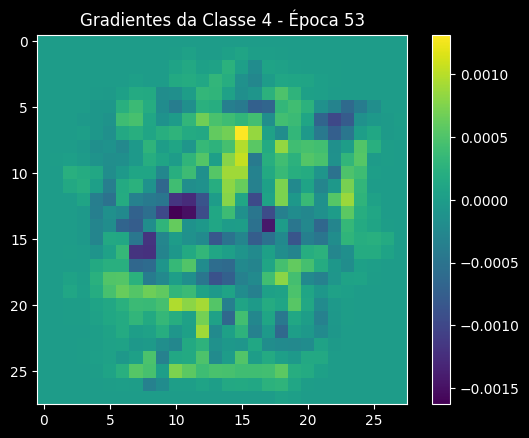

Epoch [53/100], Loss: 0.152264, Accuracy: 0.974000


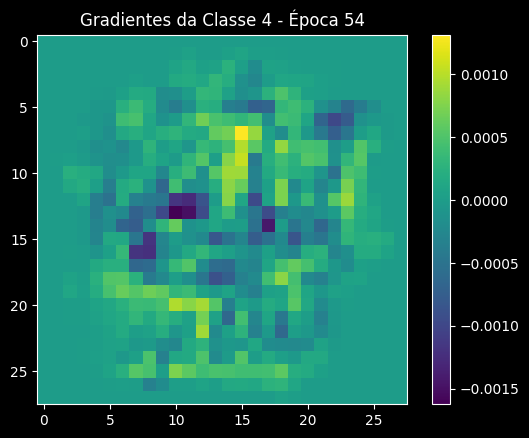

Epoch [54/100], Loss: 0.151835, Accuracy: 0.974000


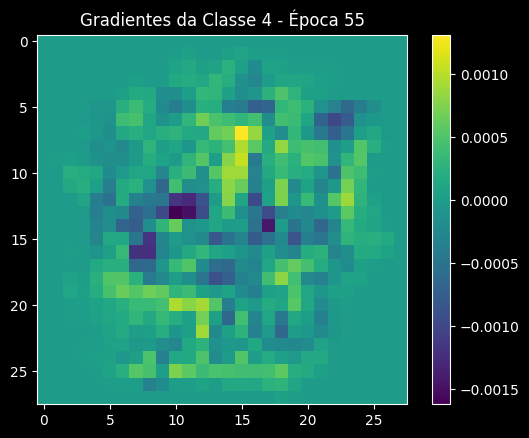

Epoch [55/100], Loss: 0.151409, Accuracy: 0.974000


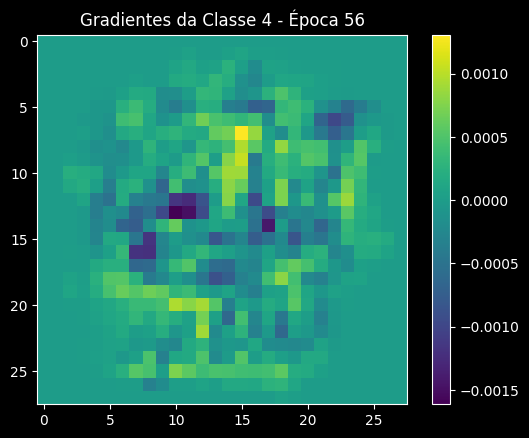

Epoch [56/100], Loss: 0.150985, Accuracy: 0.974000


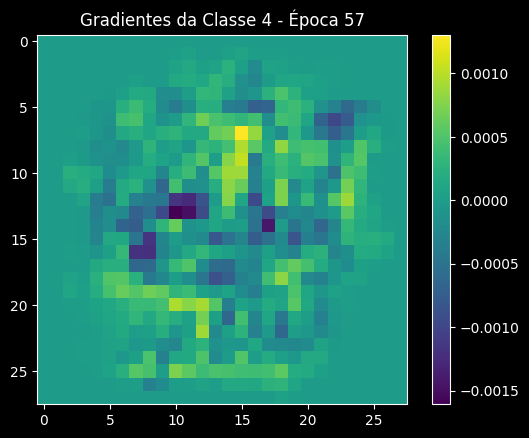

Epoch [57/100], Loss: 0.150563, Accuracy: 0.974000


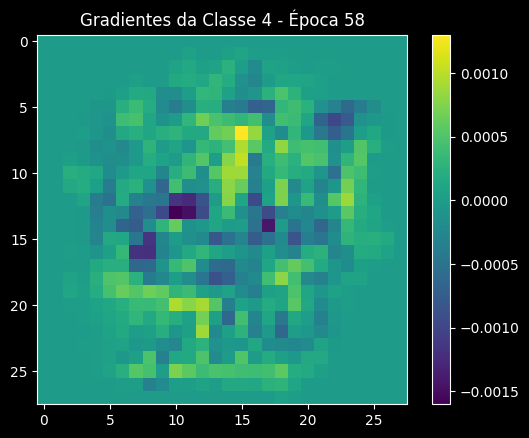

Epoch [58/100], Loss: 0.150144, Accuracy: 0.974000


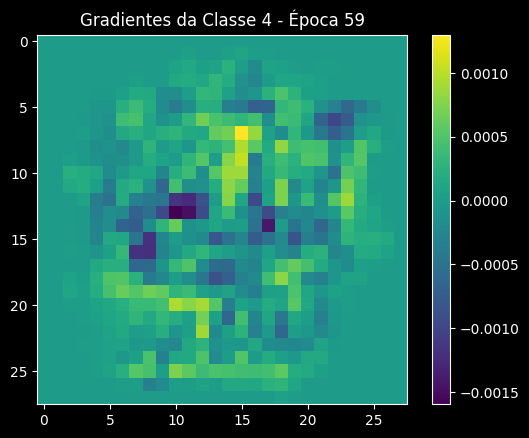

Epoch [59/100], Loss: 0.149726, Accuracy: 0.974000


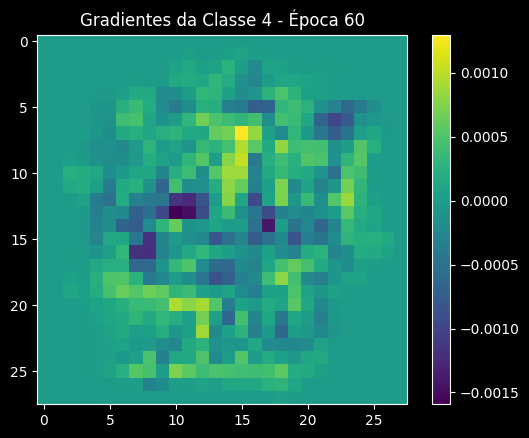

Epoch [60/100], Loss: 0.149311, Accuracy: 0.974000


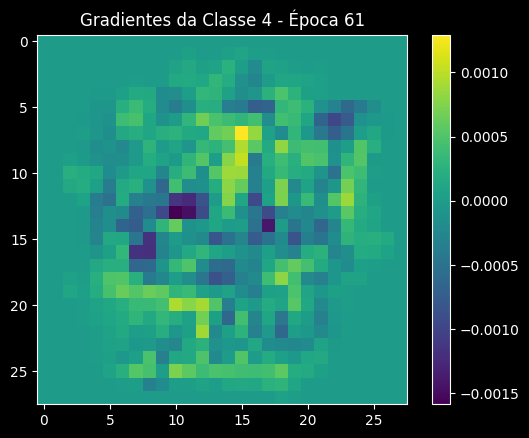

Epoch [61/100], Loss: 0.148898, Accuracy: 0.974000


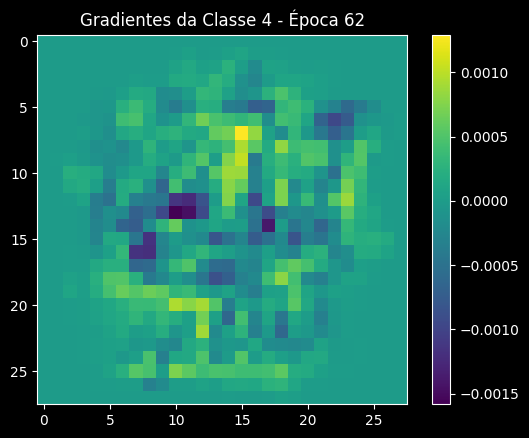

Epoch [62/100], Loss: 0.148487, Accuracy: 0.974000


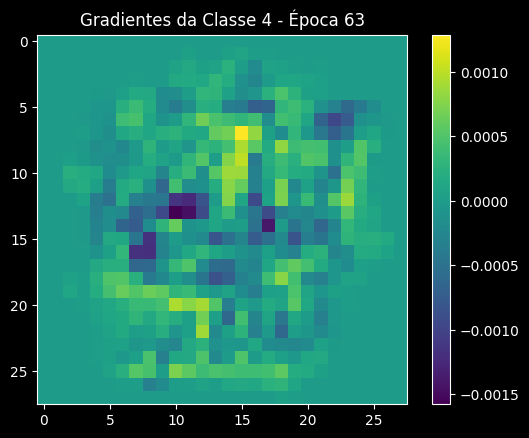

Epoch [63/100], Loss: 0.148077, Accuracy: 0.974000


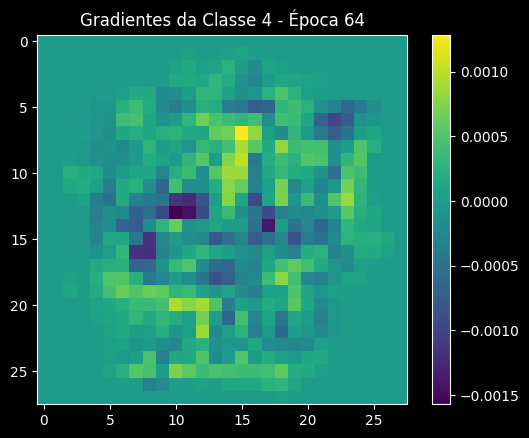

Epoch [64/100], Loss: 0.147670, Accuracy: 0.974000


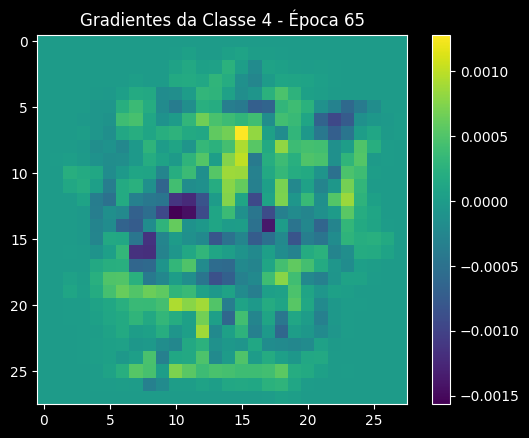

Epoch [65/100], Loss: 0.147265, Accuracy: 0.974000


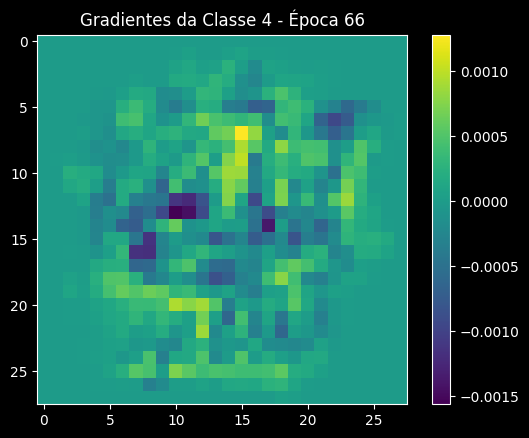

Epoch [66/100], Loss: 0.146862, Accuracy: 0.974000


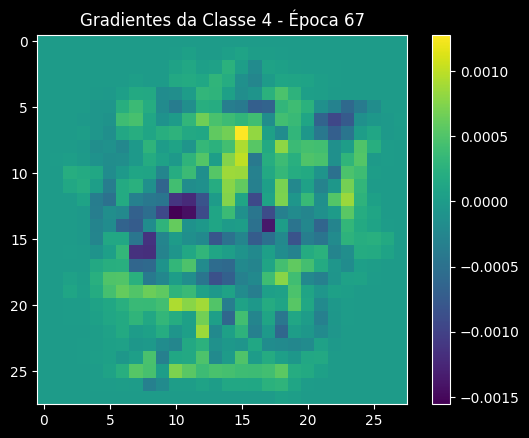

Epoch [67/100], Loss: 0.146462, Accuracy: 0.974000


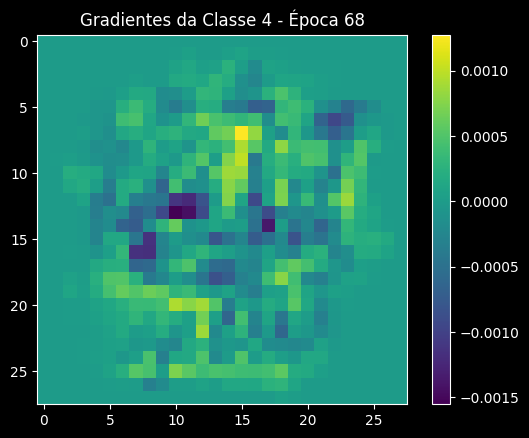

Epoch [68/100], Loss: 0.146063, Accuracy: 0.974000


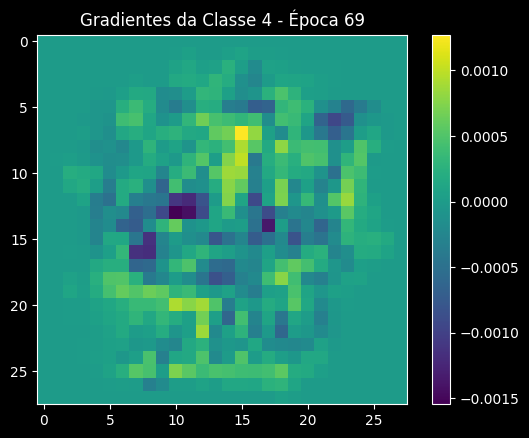

Epoch [69/100], Loss: 0.145666, Accuracy: 0.974000


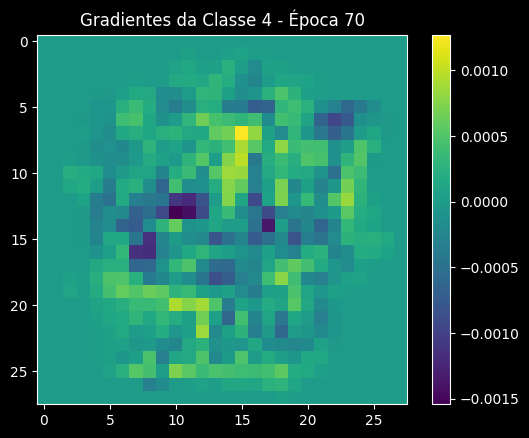

Epoch [70/100], Loss: 0.145271, Accuracy: 0.975000


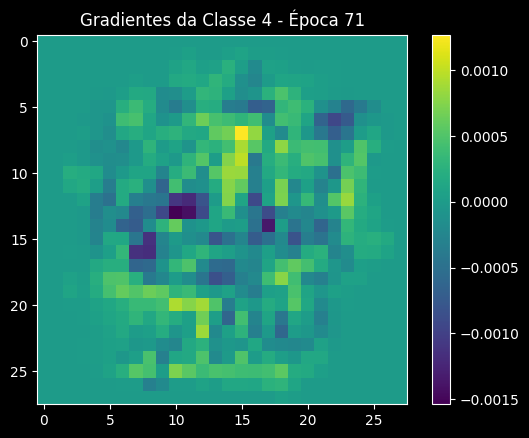

Epoch [71/100], Loss: 0.144878, Accuracy: 0.975000


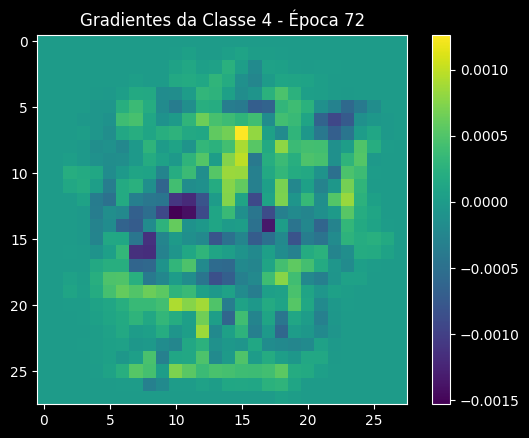

Epoch [72/100], Loss: 0.144486, Accuracy: 0.976000


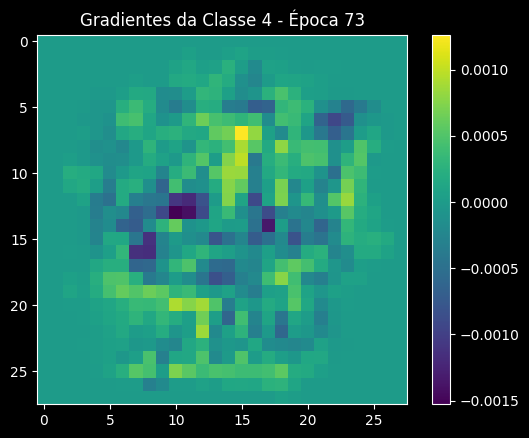

Epoch [73/100], Loss: 0.144097, Accuracy: 0.976000


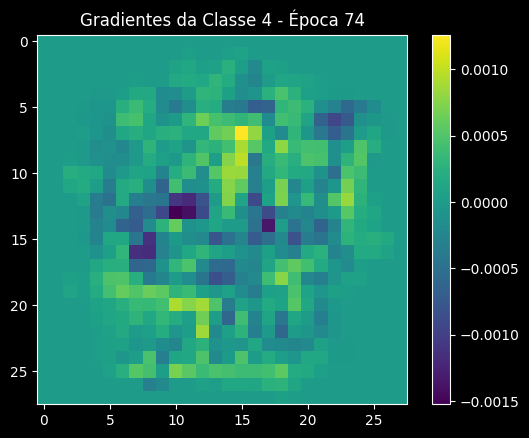

Epoch [74/100], Loss: 0.143710, Accuracy: 0.976000


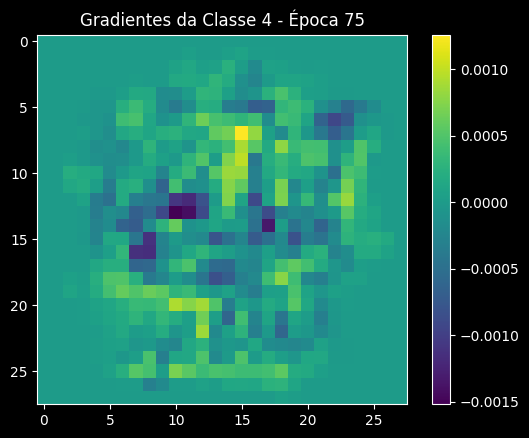

Epoch [75/100], Loss: 0.143325, Accuracy: 0.976000


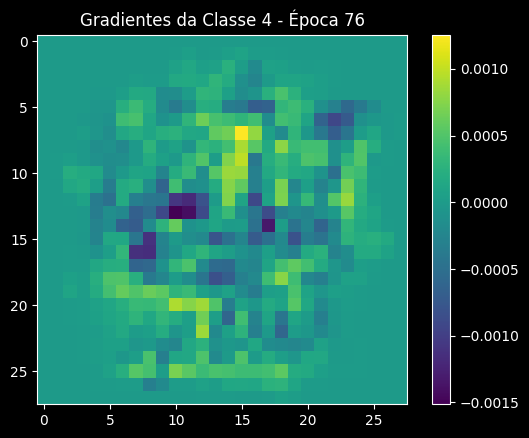

Epoch [76/100], Loss: 0.142941, Accuracy: 0.976000


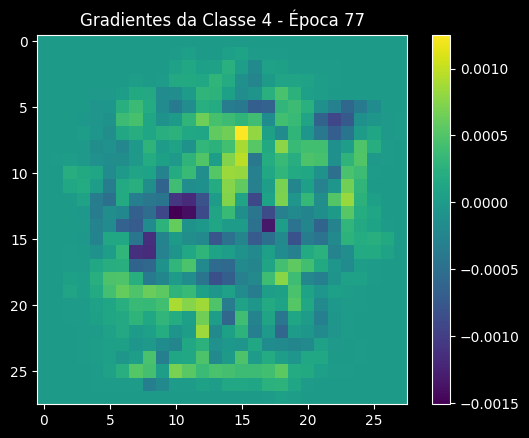

Epoch [77/100], Loss: 0.142559, Accuracy: 0.976000


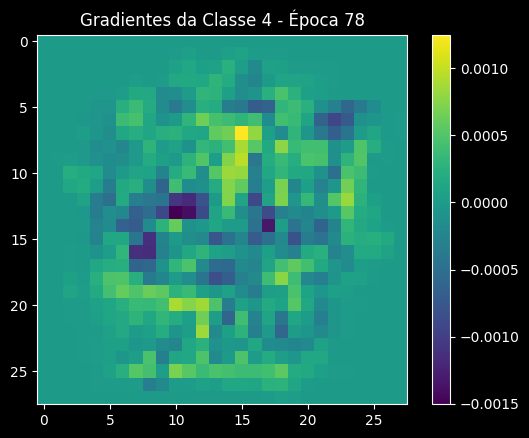

Epoch [78/100], Loss: 0.142180, Accuracy: 0.976000


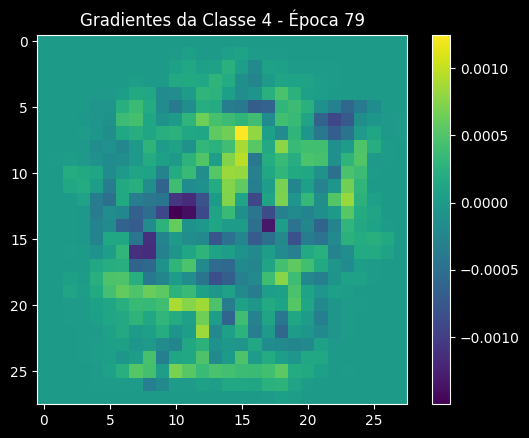

Epoch [79/100], Loss: 0.141802, Accuracy: 0.976000


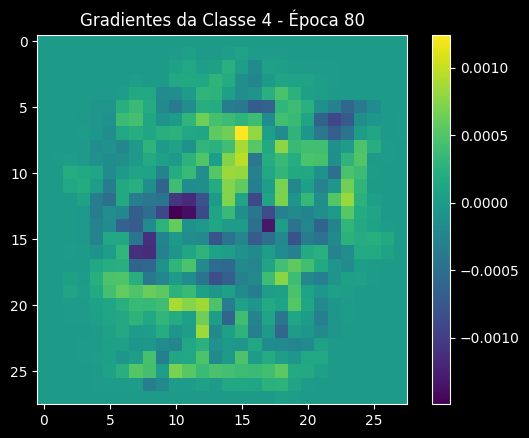

Epoch [80/100], Loss: 0.141425, Accuracy: 0.976000


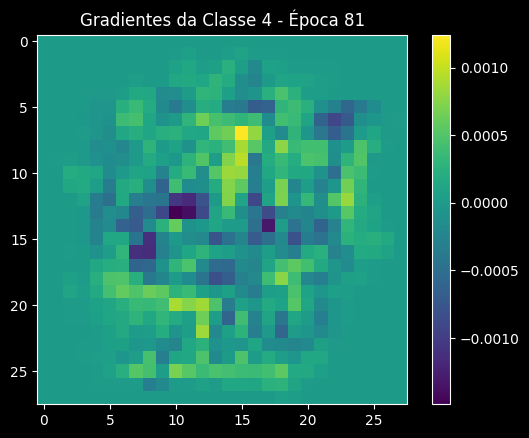

Epoch [81/100], Loss: 0.141051, Accuracy: 0.976000


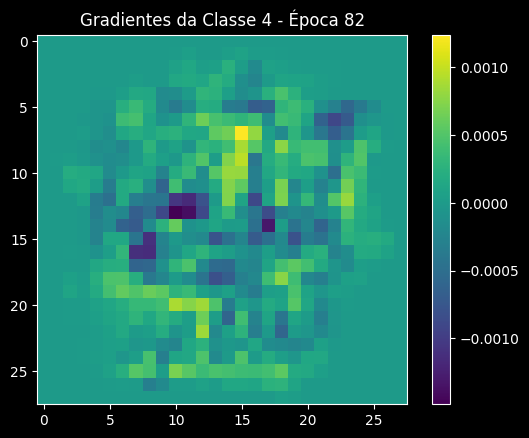

Epoch [82/100], Loss: 0.140678, Accuracy: 0.976000


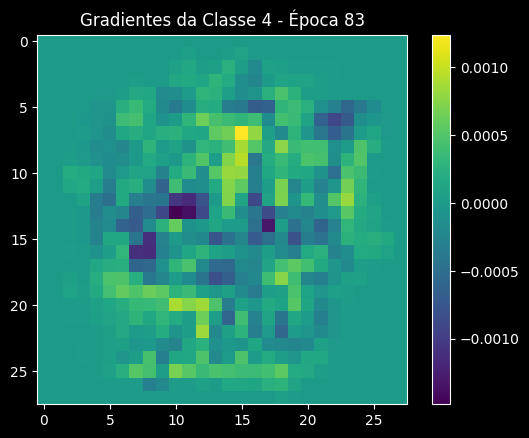

Epoch [83/100], Loss: 0.140308, Accuracy: 0.976000


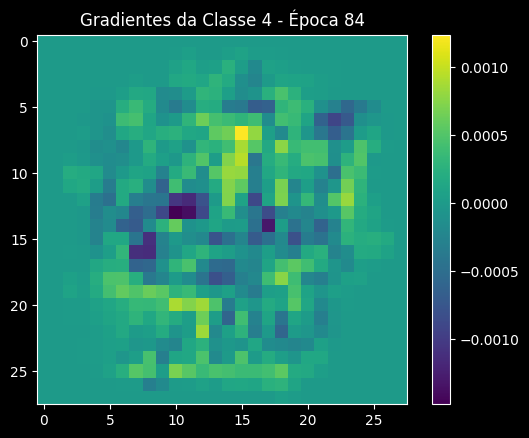

Epoch [84/100], Loss: 0.139939, Accuracy: 0.976000


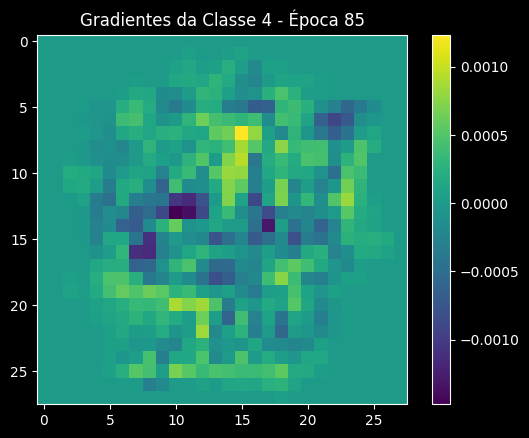

Epoch [85/100], Loss: 0.139571, Accuracy: 0.976000


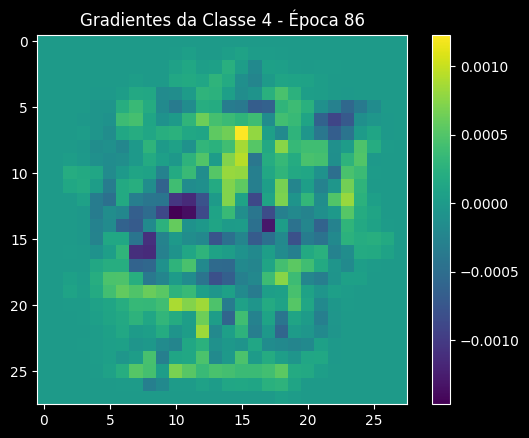

Epoch [86/100], Loss: 0.139206, Accuracy: 0.976000


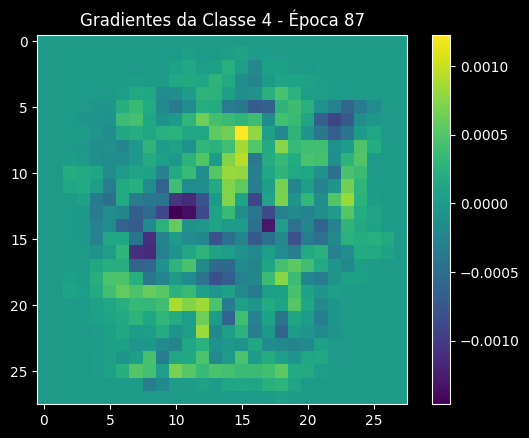

Epoch [87/100], Loss: 0.138842, Accuracy: 0.976000


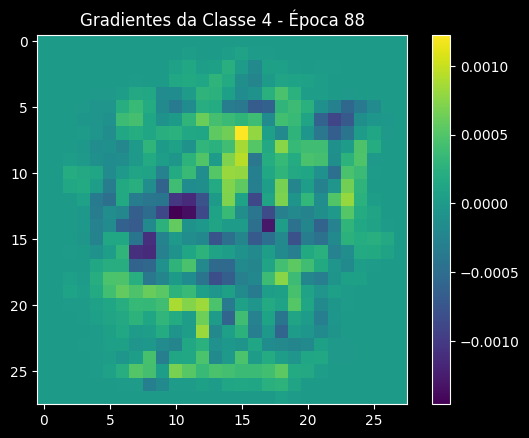

Epoch [88/100], Loss: 0.138480, Accuracy: 0.976000


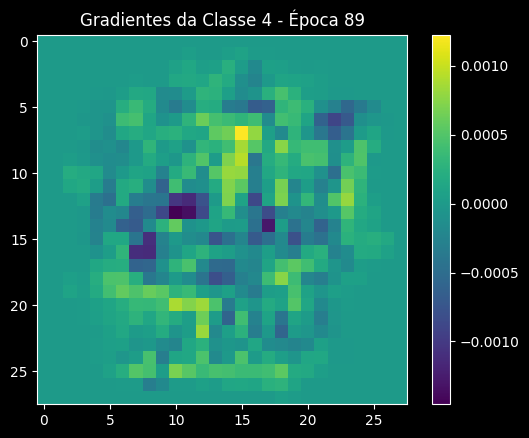

Epoch [89/100], Loss: 0.138120, Accuracy: 0.976000


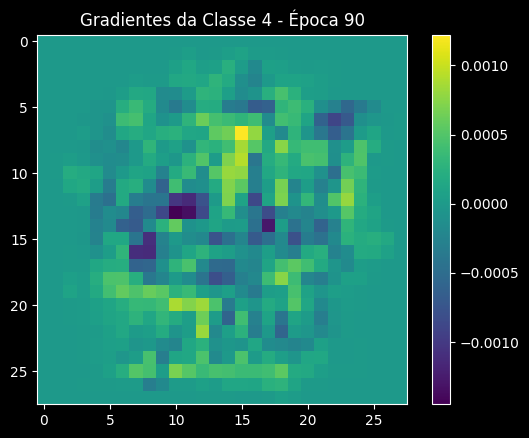

Epoch [90/100], Loss: 0.137761, Accuracy: 0.976000


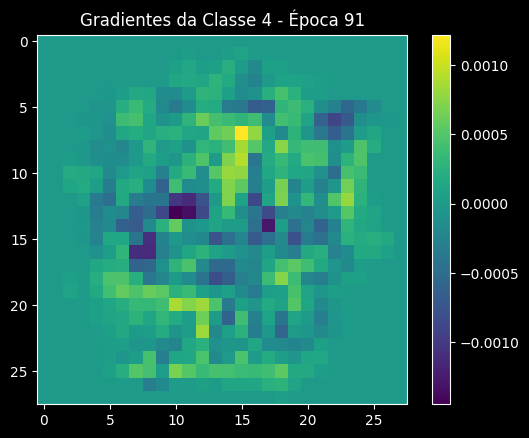

Epoch [91/100], Loss: 0.137404, Accuracy: 0.976000


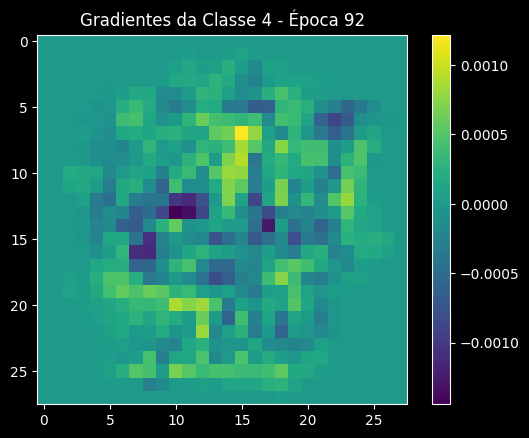

Epoch [92/100], Loss: 0.137049, Accuracy: 0.976000


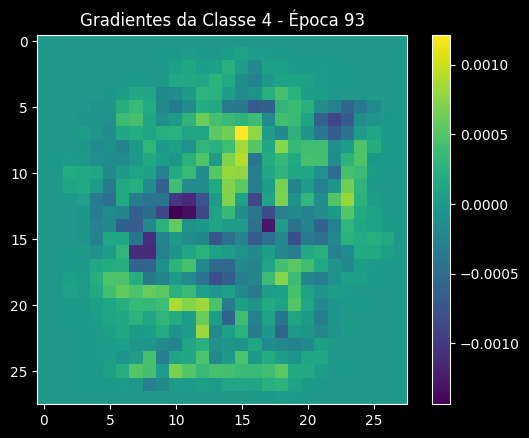

Epoch [93/100], Loss: 0.136695, Accuracy: 0.976000


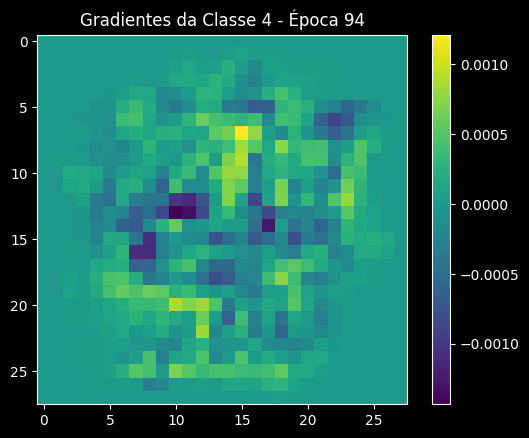

Epoch [94/100], Loss: 0.136343, Accuracy: 0.977000


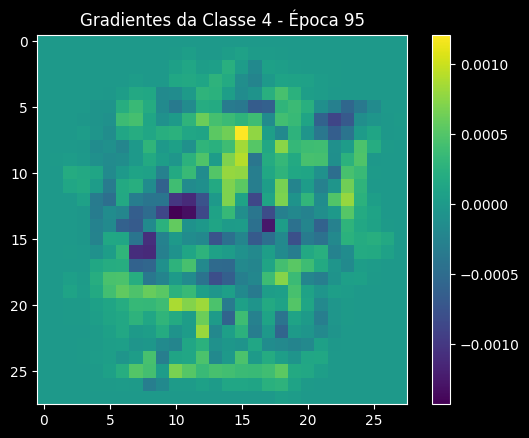

Epoch [95/100], Loss: 0.135993, Accuracy: 0.977000


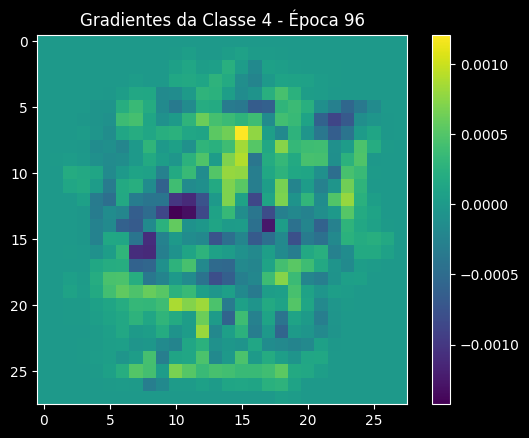

Epoch [96/100], Loss: 0.135644, Accuracy: 0.977000


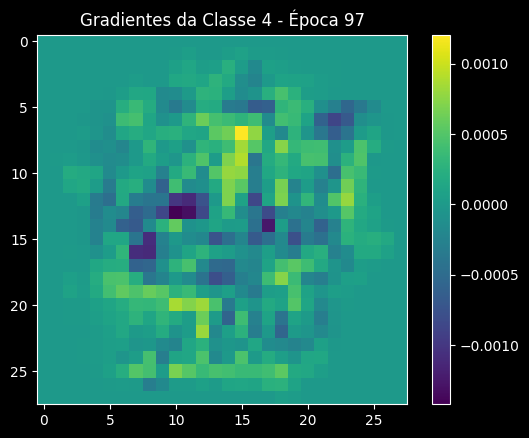

Epoch [97/100], Loss: 0.135297, Accuracy: 0.977000


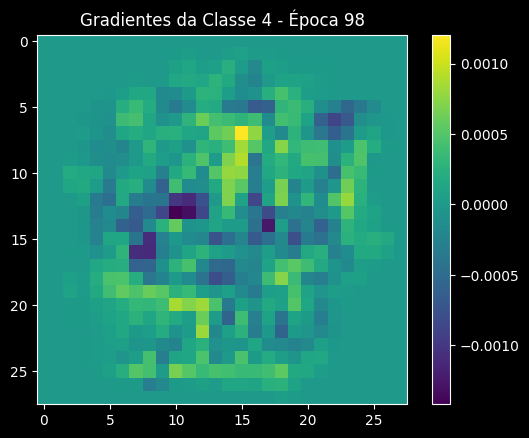

Epoch [98/100], Loss: 0.134951, Accuracy: 0.977000


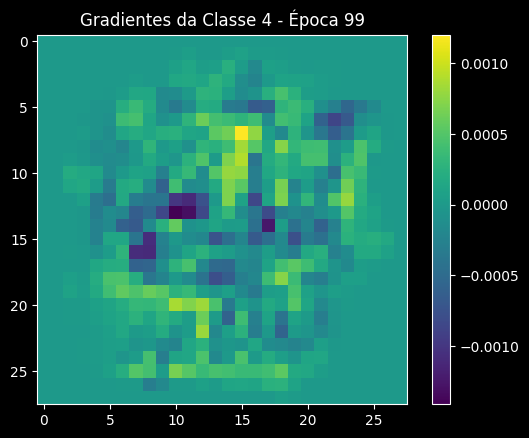

Epoch [99/100], Loss: 0.134608, Accuracy: 0.978000


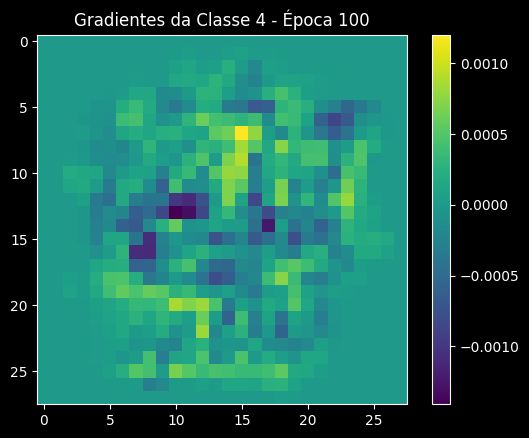

Epoch [100/100], Loss: 0.134265, Accuracy: 0.978000


In [23]:
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # Calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # Zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()

    # Visualiza os gradientes da classe do dígito 4
    gradientes_classe_4 = model.weight.grad[4].view(28, 28).detach().numpy()
    plt.imshow(gradientes_classe_4, cmap='viridis')
    plt.title(f"Gradientes da Classe 4 - Época {i+1}")
    plt.colorbar()
    plt.show()

    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    # Imprime o número da época, a perda e a acurácia
    print(f"Epoch [{i+1}/{epochs}], Loss: {loss.item():.6f}, Accuracy: {accuracy:.6f}")

## Perguntas

1. Qual é o shape da matriz de entrada na rede?  
r = O shape da matriz de entrada na rede é `(n_samples_train, 28*28)`, ou seja, `(1000, 784)`.  

2. Qual é o shape da saída da rede?  
r = O shape da saída da rede é `(n_samples_train, 10)`, ou seja, `(1000, 10)`.  

3. Qual é o número total de parâmetros da rede, incluindo o bias?  
r = O número total de parâmetros da rede, incluindo o bias, pode ser calculado como:

- A rede tem 784 entradas (`28*28`) e 10 saídas.
- O número de pesos é `784 * 10 = 7840`.
- O número de biases é igual ao número de saídas, ou seja, `10`.

Portanto, o número total de parâmetros é:

```
7840 + 10 = 7850
```

# Aprendizados


1. **Regressão Softmax**:
    - Entendimento do funcionamento da regressão softmax para classificação multiclasse.
    - Aplicação da regressão softmax em um problema real de classificação de dígitos manuscritos (MNIST).

2. **Manipulação de Dados**:
    - Carregamento e normalização de dados de imagens.
    - Seleção de subconjuntos de dados para treinamento e visualização.

3. **Visualização de Dados**:
    - Visualização de imagens do dataset MNIST.
    - Criação de grids de imagens para análise visual.
    - Visualização de pesos treinados e gradientes para interpretação do modelo.

4. **Construção de Modelos**:
    - Definição de uma rede neural simples com uma camada linear.
    - Configuração de hiperparâmetros como taxa de aprendizado e número de épocas.

5. **Treinamento de Modelos**:
    - Implementação do laço de treinamento com cálculo de perda e ajuste de pesos.
    - Uso de funções de perda como `CrossEntropyLoss`.
    - Otimização com gradiente descendente usando `torch.optim.SGD`.

6. **Avaliação de Modelos**:
    - Cálculo da acurácia no conjunto de treinamento.
    - Construção de uma matriz de confusão para análise de desempenho.

7. **Interpretação de Pesos**:
    - Visualização dos pesos treinados para cada classe.
    - Análise da importância dos pesos associados a cada pixel para diferentes classes.

8. **Visualização de Gradientes**:
    - Monitoramento dos gradientes durante o treinamento para entender o impacto das atualizações nos pesos.

9. **Gráficos de Perda**:
    - Plotagem do gráfico de perda ao longo das épocas para avaliar a convergência do modelo.

10. **Análise de Parâmetros**:
     - Cálculo do número total de parâmetros da rede (pesos e bias).
     - Entendimento do impacto do número de parâmetros no desempenho do modelo.

11. **Uso de Ferramentas**:
     - Uso de bibliotecas como PyTorch, Matplotlib e Torchvision para manipulação de dados, construção de modelos e visualização.

12. **Interpretação de Resultados**:
     - Análise dos resultados obtidos, como perda final, acurácia e comportamento dos gradientes, para avaliar o desempenho do modelo.

13. **Documentação e Organização**:
     - Importância de documentar cada etapa do processo para facilitar o entendimento e a reprodução do experimento.